In [218]:
import pandas as pd #library untuk dataframe
import numpy as np #library untuk tipe data numpy array

from sklearn.metrics.pairwise import cosine_similarity #library untuk menghitung cosine similarity
from sklearn.feature_extraction.text import CountVectorizer #library untuk menghitung tf-idf
import nltk #library untuk natural language processing
nltk.download('stopwords') #library untuk stopwords

from sklearn.feature_extraction import text #library untuk ekstarksi fitur tf-idf
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer #library untuk menghitung tf-idf

from nltk.corpus import stopwords #library untuk stopwords
from openpyxl import load_workbook #library untuk menampilkan dokumen
from nltk.tokenize import word_tokenize #import library nltk - tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory #import library sastrawi untuk stemming

[nltk_data] Downloading package stopwords to C:\Users\a c e
[nltk_data]     r\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


memuat data dari file csv

In [219]:
wr = load_workbook(filename = 'Dataset.xlsx')
sheet_range = wr['Sheet1']

df = pd.DataFrame(sheet_range.values)
#df.columns = ['No','Judul', 'Deskripsi']
df2 = df[[2,3,4,5]].iloc[1:-1].copy()
df2.columns = ['Judul', 'Deskripsi','Rubrik', 'Tag']
df2['Deskripsi'] =df2['Judul'] + ". " +  df2['Deskripsi']+'. '+df2['Tag'] 
df2 = df2.reset_index(drop=True)    
df2.head()

,Judul,Deskripsi,Rubrik,Tag
0,"Jelang KTT G20, Menko Luhut Resmikan PLTS Tera...","Jelang KTT G20, Menko Luhut Resmikan PLTS Tera...",Nasional,"plts terapung, energi baru terbarukan, PLN"
1,PLN Berhasil Reduksi 32 Juta Metrik Ton Emisi ...,PLN Berhasil Reduksi 32 Juta Metrik Ton Emisi ...,Nasional,"reduksi, emisi karbon, PLN"
2,Instalasi PLN Dua Pekon di Suoh Masuk Roadmap ...,Instalasi PLN Dua Pekon di Suoh Masuk Roadmap ...,Nasional,"roadmap, instalasi, listrik, jaringan, PLN"
3,"Jelang KTT G20, PLN Pamerkan Dua PLTS dan 33 P...","Jelang KTT G20, PLN Pamerkan Dua PLTS dan 33 P...",Nasional,"plts, g20, PLN"
4,"Jaga Pasokan Listrik KTT G20, PLN Operasikan P...","Jaga Pasokan Listrik KTT G20, PLN Operasikan P...",Nasional,"pltg, g20, pasokan listrik, PLN"


In [220]:
df2['Judul'][42]

'Pasca Kerusuhan Kanjuruhan, Polri Susun Aturan Pengamanan Sepakbola'

In [221]:
before_prepro = df2
JudulIndeks = pd.DataFrame(df2['Judul'])
JudulIndeks['IndeksMaster'] = JudulIndeks.index
JudulIndeks.head()
JudulIndeks.to_csv('JudulIndeks.csv', index=False)

### Pre-processing

Cleaning

In [222]:
df2['Deskripsi'] = df2['Deskripsi'].str.replace(r'[^\w\s]+', ' ').str.replace('\d+', '')
df2.head()

C:\Users\a c e r\AppData\Local\Temp\ipykernel_8600\2652559791.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df2['Deskripsi'] = df2['Deskripsi'].str.replace(r'[^\w\s]+', ' ').str.replace('\d+', '')


,Judul,Deskripsi,Rubrik,Tag
0,"Jelang KTT G20, Menko Luhut Resmikan PLTS Tera...",Jelang KTT G Menko Luhut Resmikan PLTS Terapu...,Nasional,"plts terapung, energi baru terbarukan, PLN"
1,PLN Berhasil Reduksi 32 Juta Metrik Ton Emisi ...,PLN Berhasil Reduksi Juta Metrik Ton Emisi Ka...,Nasional,"reduksi, emisi karbon, PLN"
2,Instalasi PLN Dua Pekon di Suoh Masuk Roadmap ...,Instalasi PLN Dua Pekon di Suoh Masuk Roadmap ...,Nasional,"roadmap, instalasi, listrik, jaringan, PLN"
3,"Jelang KTT G20, PLN Pamerkan Dua PLTS dan 33 P...",Jelang KTT G PLN Pamerkan Dua PLTS dan PV Ro...,Nasional,"plts, g20, PLN"
4,"Jaga Pasokan Listrik KTT G20, PLN Operasikan P...",Jaga Pasokan Listrik KTT G PLN Operasikan PLT...,Nasional,"pltg, g20, pasokan listrik, PLN"


case folding

In [223]:
df2['Deskripsi'] = df2['Deskripsi'].str.lower()
df2.head()

,Judul,Deskripsi,Rubrik,Tag
0,"Jelang KTT G20, Menko Luhut Resmikan PLTS Tera...",jelang ktt g menko luhut resmikan plts terapu...,Nasional,"plts terapung, energi baru terbarukan, PLN"
1,PLN Berhasil Reduksi 32 Juta Metrik Ton Emisi ...,pln berhasil reduksi juta metrik ton emisi ka...,Nasional,"reduksi, emisi karbon, PLN"
2,Instalasi PLN Dua Pekon di Suoh Masuk Roadmap ...,instalasi pln dua pekon di suoh masuk roadmap ...,Nasional,"roadmap, instalasi, listrik, jaringan, PLN"
3,"Jelang KTT G20, PLN Pamerkan Dua PLTS dan 33 P...",jelang ktt g pln pamerkan dua plts dan pv ro...,Nasional,"plts, g20, PLN"
4,"Jaga Pasokan Listrik KTT G20, PLN Operasikan P...",jaga pasokan listrik ktt g pln operasikan plt...,Nasional,"pltg, g20, pasokan listrik, PLN"


stopword removal


In [224]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
stop_factory = StopWordRemoverFactory()
data = stop_factory.get_stop_words() 
stopword = stop_factory.create_stop_word_remover()

In [225]:

def Stopword_sastrawi (docs):
    stopword = stop_factory.create_stop_word_remover()
    return stopword.remove(docs)


In [226]:
df2['Deskripsi'] = df2['Deskripsi'].apply(Stopword_sastrawi)

In [227]:
df2['Deskripsi'][48]

'pemerintah rencanakan penghentian siaran tv analog per hari  masyarakat diharap bersiap  per hari   november   pemerintah pusat bersama kementerian komunikasi informasi  kominfo  berencana mengentikan siaran tv analog beralih siaran digital  karenanya  pemerintah provinsi lampung meminta masyarakat bersiap  kepala dinas komunikasi  informasi statistik  diskominfotik  provinsi lampung  ganjar jationo menyebut saat provinsi lampung menunggu penerapan peralihan siaran tv analog siaran tv digital  pembagiannya langsung dikirimkan rumah keluarga miskin masing masing syarat masuk data dtks  memiliki televisi masuk wilayah telah beralih layanan siaran tv digital   ganjar menyebut memang per  november siaran tv analog itu sudah diakses  masyarakat bisa langsung mencoba membeli stb  tv analog  tv digital  saluran tv digital  kemenkominfo'

stemming

In [228]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def Stemming_sastrawi (docs):
    stemmer = factory.create_stemmer()
    return stemmer.stem(docs)

df2['Deskripsi'] = df2['Deskripsi'].apply(Stemming_sastrawi)

In [229]:
Stemming_sastrawi('perawat sedang merawat pasien')

'awat sedang rawat pasien'

In [230]:
deskripsi = df2['Deskripsi'].tolist()

### Sesi Cosine dan TF IDF


In [231]:
komentar = [] #deklarasi variabel komentar pada list
komentar = df2['Deskripsi'].values.tolist() #masukan data kedalam list


https://yunusmuhammad007.medium.com/tf-idf-term-frequency-inverse-document-frequency-representasi-vector-data-text-2a4eff56cda

#### IGNORE THIS
ekperimental 

In [232]:
        
        df_cari = df2[['Judul', 'Deskripsi']]
        df_cari = pd.DataFrame([['CARI2', 'Narkoba']], columns=df_cari.columns).append(df_cari)
        komentar = [] #deklarasi variabel komentar pada list
        komentar = df_cari['Deskripsi'].values.tolist() #masukan data kedalam list
        
        
        from sklearn.feature_extraction.text import TfidfVectorizer
        tf_idf = TfidfVectorizer(binary=True)
        tfidf_mat = tf_idf.fit_transform(df_cari["Deskripsi"]).toarray()
        x = tfidf_mat
        
        from sklearn.metrics.pairwise import cosine_similarity
        df3 = pd.DataFrame(cosine_similarity(x, dense_output=True))
        
        indices = pd.Series(df_cari.Judul)
        indices.index = range(0, len(df_cari))
        
        def recomend (title, cosine_sim):
    
            result = []
            idx = indices[indices == title].index[0]
            print (idx)
            
            score = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
            top_10 = list(score.iloc[1:6].index)
            #result = indices[top_10]
            return top_10   
        
        judul = "CARI2"
        result_stem = recomend(judul, df3)
        print(result_stem)
        print(indices[result_stem])

0
[58, 55, 59, 57, 60]
58    Musnahkan Barang Bukti Narkoba Ratusan Kilogra...
55    Oknum Jaksa di Lampung Utara Tersangka Kepemil...
59    Heboh Video Penangkapan Pengedar Sabu, Polisi ...
57    Soal 4 Pelaku Penyalahgunaan Narkoba yang Dibe...
60          Warga Pringsewu Ditangkap, BB Sabu dan Bong
Name: Judul, dtype: object


C:\Users\a c e r\AppData\Local\Temp\ipykernel_8600\333108848.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_cari = pd.DataFrame([['CARI2', 'Narkoba']], columns=df_cari.columns).append(df_cari)


### TF-IDF Buat Sendiri

In [233]:

 #Example text corpus for our tutorial
text = deskripsi
 
#Tokenisasi
sentences = []
word_set = []
 
for sent in text:
    x = [i.lower() for  i in word_tokenize(sent) if i.isalpha()]
    sentences.append(x)
    for word in x:
        if word not in word_set:
            word_set.append(word)
 
#mengatur vokabulari
word_set = set(word_set)

#total dokumen pada korpus
total_documents = len(sentences)
 
#indeks vocab
index_dict = {} #Dictionary to store index for each word
i = 0
for word in word_set:
    index_dict[word] = i
    i += 1

In [234]:
#menghitung  DF
def count_dict(sentences):
    word_count = {}
    for word in word_set:
        word_count[word] = 0
        for sent in sentences:
            if word in sent:
                word_count[word] += 1
    return word_count
 
word_count = count_dict(sentences)

In [235]:
#Menghitung TF
def termfreq(document, word):
    N = len(document)
    occurance = len([token for token in document if token == word])
    return occurance/N

In [236]:
#menghitung IDF
def inverse_doc_freq(word):
    try:
        word_occurance = word_count[word] + 1
    except:
        word_occurance = 1
    return np.log(total_documents/word_occurance)

In [237]:
#menghitung TF-IDF
def tf_idf(sentence):
    tf_idf_vec = np.zeros((len(word_set),))
    for word in sentence:
        tf = termfreq(sentence,word)
        idf = inverse_doc_freq(word)
 
        value = tf*idf
        
        print(word, tf, idf, value)
        tf_idf_vec[index_dict[word]] = value 
    return tf_idf_vec

In [238]:
vectors = []
for sent in sentences:
    vec = tf_idf(sent)
    vectors.append(vec)
 


jelang 0.01282051282051282 2.995732273553991 0.03840682401992296
ktt 0.02564102564102564 2.4849066497880004 0.06371555512276923
g 0.02564102564102564 2.302585092994046 0.05904064341010374
menko 0.01282051282051282 3.4011973816621555 0.0436050946366943
luhut 0.02564102564102564 3.4011973816621555 0.0872101892733886
resmi 0.02564102564102564 2.302585092994046 0.05904064341010374
plts 0.038461538461538464 2.70805020110221 0.10415577696546963
apung 0.038461538461538464 2.995732273553991 0.11522047205976889
milik 0.02564102564102564 1.2039728043259361 0.030871097546818875
pln 0.05128205128205128 2.1484344131667874 0.11017612375214295
bal 0.01282051282051282 2.70805020110221 0.034718592321823206
menteri 0.01282051282051282 2.70805020110221 0.034718592321823206
koordinator 0.01282051282051282 3.4011973816621555 0.0436050946366943
bidang 0.01282051282051282 1.791759469228055 0.022971275246513524
maritim 0.01282051282051282 3.4011973816621555 0.0436050946366943
investasi 0.01282051282051282 2.9

In [239]:
vectors = np.array(vectors)

In [240]:
vectors.shape

(60, 1627)

In [241]:
x4 = pd.DataFrame(vectors)
x5 = x4.transpose()

In [242]:
A = np.array(x5[0])
B = np.array(x5[1])

In [243]:
import numpy as np
from numpy.linalg import norm
 
# define two lists or array
#A = np.array([2,1,2,3,2,9])
#B = np.array([3,4,2,4,5,5])

#A = np.array(x5[0])
#B = np.array(x5[1])
print("A:", A)
print("B:", B)
 
# compute cosine similarity
cosine = np.dot(A,B)/(norm(A)*norm(B))
print("Cosine Similarity:", cosine)

A: [0. 0. 0. ... 0. 0. 0.]
B: [0. 0. 0. ... 0. 0. 0.]
Cosine Similarity: 0.16808662110611602


#### Cek frekuensi kata dari dokumen

In [244]:
def freq(str):
    str = str.split()        
    str2 = []
    for i in str:            
        #cek duplikasi
        if i not in str2:
             str2.append(i)
    for i in range(0, len(str2))   :       
        if str2[i] == "luhut":
            print('Frequency kata ', str2[i], 'adalah :', str.count(str2[i]))   

corpus = deskripsi
corpus = ' '.join(deskripsi)
corpus

str = deskripsi[0]
freq(str)

Frequency kata  luhut adalah : 2


https://stackoverflow.com/questions/36966019/how-aretf-idf-calculated-by-the-scikit-learn-tfidfvectorizer

### Cosine

In [245]:
from sklearn.metrics.pairwise import cosine_similarity
df3 = pd.DataFrame(cosine_similarity(vectors, dense_output=False))
df5 = df3.copy()
df5.reset_index(drop=True)
df5.to_csv('cosine_similarity.csv', index=False)
df5.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,1.000000,0.168087,0.112615,0.451312,0.353829,0.446871,0.006759,0.060532,0.005664,0.017178,0.010879,0.000000,0.008563,0.000458,0.000441,0.003850,0.006595,0.000000,0.007216,0.022564,0.004610,0.023166,0.005506,0.004445,0.010535,0.007005,0.007159,0.016155,0.014300,0.004057,0.051191,0.009078,0.023016,0.006657,0.023033,0.007747,0.102232,0.031114,0.036409,0.015858,0.077712,0.020761,0.000263,0.000244,0.000292,0.015633,0.000000,0.000809,0.024632,0.017073,0.017691,0.022160,0.023500,0.031543,0.010396,0.009674,0.000577,0.006089,0.005457,0.017419
1,0.168087,1.000000,0.105896,0.176326,0.157706,0.221104,0.016654,0.023521,0.015589,0.019189,0.000298,0.012790,0.006757,0.006477,0.006224,0.005400,0.013615,0.003194,0.009650,0.017481,0.007372,0.012383,0.018237,0.021161,0.033234,0.014816,0.009405,0.002736,0.000000,0.000000,0.010936,0.013443,0.019758,0.007276,0.006583,0.011643,0.018269,0.017125,0.034398,0.012916,0.017767,0.007097,0.003308,0.001879,0.004211,0.017563,0.011637,0.007771,0.010583,0.007000,0.009752,0.001866,0.004723,0.003396,0.003355,0.020519,0.003726,0.000000,0.013818,0.016501
2,0.112615,0.105896,1.000000,0.109903,0.105552,0.108016,0.009448,0.008859,0.026167,0.003430,0.036214,0.025334,0.022978,0.013809,0.007337,0.004807,0.057420,0.011429,0.012525,0.017079,0.038731,0.046436,0.014216,0.025730,0.014967,0.011993,0.028826,0.059867,0.005753,0.011484,0.006499,0.021517,0.044116,0.016932,0.015832,0.027254,0.025909,0.004904,0.013638,0.022747,0.085137,0.013344,0.045532,0.013358,0.005663,0.008213,0.000000,0.009740,0.070802,0.005203,0.021439,0.005801,0.058648,0.040120,0.015222,0.008990,0.013880,0.004591,0.037458,0.021157
3,0.451312,0.176326,0.109903,1.000000,0.365475,0.385329,0.007321,0.006683,0.006193,0.007370,0.008614,0.003247,0.020269,0.000000,0.000000,0.008910,0.002333,0.000000,0.028086,0.029205,0.012146,0.030660,0.017957,0.004522,0.000722,0.007954,0.016449,0.009114,0.028756,0.001317,0.009141,0.005813,0.010267,0.004774,0.002804,0.026766,0.015698,0.007065,0.009378,0.004879,0.025400,0.006448,0.003982,0.000992,0.002259,0.005278,0.000000,0.008730,0.002165,0.011746,0.013679,0.000000,0.003072,0.000000,0.003966,0.003974,0.004891,0.004060,0.008606,0.001288
4,0.353829,0.157706,0.105552,0.365475,1.000000,0.197106,0.011945,0.007407,0.011284,0.012817,0.024694,0.010880,0.001858,0.001263,0.000000,0.013900,0.001633,0.000000,0.004262,0.029198,0.003647,0.027273,0.009707,0.004683,0.006041,0.000408,0.000000,0.002205,0.022237,0.000000,0.008162,0.007852,0.006835,0.003779,0.004090,0.012378,0.038200,0.005015,0.017590,0.006375,0.104410,0.013080,0.008633,0.010938,0.023852,0.008339,0.014597,0.009268,0.001860,0.003958,0.012801,0.007772,0.003206,0.001567,0.004441,0.018880,0.006659,0.007704,0.005221,0.009693


### Rekomendasi Cosine Similarity

In [246]:
indices = pd.Series(df2.Judul)
indices.index = range(0, len(df2))
indices[:5]


0    Jelang KTT G20, Menko Luhut Resmikan PLTS Tera...
1    PLN Berhasil Reduksi 32 Juta Metrik Ton Emisi ...
2    Instalasi PLN Dua Pekon di Suoh Masuk Roadmap ...
3    Jelang KTT G20, PLN Pamerkan Dua PLTS dan 33 P...
4    Jaga Pasokan Listrik KTT G20, PLN Operasikan P...
Name: Judul, dtype: object

In [247]:
def recomend (title, cosine_sim):
    
    result = []
    idx = indices[indices == title].index[0]
    print (idx)
    
    score = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
    top_5 = list(score.iloc[1:6].index)
    return top_5    

In [248]:
judul = "Jelang KTT G20, Menko Luhut Resmikan PLTS Terapung Milik PLN di Bali"
result_stem = recomend(judul, df3)
print(result_stem)
print(indices[result_stem])

0
[3, 5, 4, 1, 2]
3    Jelang KTT G20, PLN Pamerkan Dua PLTS dan 33 P...
5    Wujudkan Transisi Energi, PLN Siap Kerjakan Pr...
4    Jaga Pasokan Listrik KTT G20, PLN Operasikan P...
1    PLN Berhasil Reduksi 32 Juta Metrik Ton Emisi ...
2    Instalasi PLN Dua Pekon di Suoh Masuk Roadmap ...
Name: Judul, dtype: object


#### mencari seluruh rekomendasi

In [249]:
df2.head()

,Judul,Deskripsi,Rubrik,Tag
0,"Jelang KTT G20, Menko Luhut Resmikan PLTS Tera...",jelang ktt g menko luhut resmi plts apung mili...,Nasional,"plts terapung, energi baru terbarukan, PLN"
1,PLN Berhasil Reduksi 32 Juta Metrik Ton Emisi ...,pln hasil reduksi juta metrik ton emisi karbon...,Nasional,"reduksi, emisi karbon, PLN"
2,Instalasi PLN Dua Pekon di Suoh Masuk Roadmap ...,instalasi pln pekon suoh masuk roadmap pln pas...,Nasional,"roadmap, instalasi, listrik, jaringan, PLN"
3,"Jelang KTT G20, PLN Pamerkan Dua PLTS dan 33 P...",jelang ktt g pln pamer plts pv rooftop bal pt ...,Nasional,"plts, g20, PLN"
4,"Jaga Pasokan Listrik KTT G20, PLN Operasikan P...",jaga pasok listrik ktt g pln operasi pltg relo...,Nasional,"pltg, g20, pasokan listrik, PLN"


In [250]:
Result_of_recomendation = []
for i in df2["Judul"]:
    result = recomend(i, df3)
    Result_of_recomendation.append(result)

df2["Cossine Rekomend"] = Result_of_recomendation

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


In [251]:
df2.head()
x2 = df2
x2.head()


,Judul,Deskripsi,Rubrik,Tag,Cossine Rekomend
0,"Jelang KTT G20, Menko Luhut Resmikan PLTS Tera...",jelang ktt g menko luhut resmi plts apung mili...,Nasional,"plts terapung, energi baru terbarukan, PLN","[3, 5, 4, 1, 2]"
1,PLN Berhasil Reduksi 32 Juta Metrik Ton Emisi ...,pln hasil reduksi juta metrik ton emisi karbon...,Nasional,"reduksi, emisi karbon, PLN","[5, 3, 0, 4, 2]"
2,Instalasi PLN Dua Pekon di Suoh Masuk Roadmap ...,instalasi pln pekon suoh masuk roadmap pln pas...,Nasional,"roadmap, instalasi, listrik, jaringan, PLN","[0, 3, 5, 1, 4]"
3,"Jelang KTT G20, PLN Pamerkan Dua PLTS dan 33 P...",jelang ktt g pln pamer plts pv rooftop bal pt ...,Nasional,"plts, g20, PLN","[0, 5, 4, 1, 2]"
4,"Jaga Pasokan Listrik KTT G20, PLN Operasikan P...",jaga pasok listrik ktt g pln operasi pltg relo...,Nasional,"pltg, g20, pasokan listrik, PLN","[3, 0, 5, 1, 2]"


### Jaccard

In [252]:
# Fungsi interseksi (irisan)
def intersection(doc_1, doc_2):
    return doc_1.intersection(doc_2)

# Funssi union (Gabungan)
def union(doc_1, doc_2):
    return doc_1.union(doc_2)

# Fungsi Jaccard Similarity
def jaccard_similarity(doc_1, doc_2): 
    
    words_doc_1 = doc_1.lower().split(' ')
    #print(words_doc_1)
    #print(words_doc_1)
    words_doc_2 = doc_2.lower().split(' ')
    
    words_doc_1_set = set(words_doc_1)
    words_doc_2_set = set(words_doc_2)
    
    intersection_docs = intersection(words_doc_1_set, words_doc_2_set)

    union_docs = union(words_doc_1_set, words_doc_2_set)
    print("----------INTER-----------")
    print(intersection_docs)
    print("------------------")
    print (len(intersection_docs), "--", len(union_docs))
    return len(intersection_docs) / len(union_docs)


doc_1 = "randi adalah anak yang baik dan sopan, randi tidak pernah melawan perkataan orang tua"
doc_2 = "udin adalah anak yang rajin, udin mendengar nasehat orang tuanya dengan baik"
doc_3 = "sepeda motor adalah kendaraan yang memiliki volume sangat tinggi di jalan raya"
doc_4 = "randi adalah anak yang tidak buruk dan sopan, randi tidak pernah melawan perkataan orang tua"

a = deskripsi[0]
b = deskripsi[1]

#print("doc_1 - '%s'" % (a, ))
#print("doc_2 - '%s'" % (b, ))
print("Jaccard_similarity(doc_1, doc_2) = %s" % (jaccard_similarity(a, b)))


----------INTER-----------
{'pln', 'bangkit', 'kapasitas', 'sebut', 'baru', 'ebt', 'energi'}
------------------
7 -- 102
Jaccard_similarity(doc_1, doc_2) = 0.06862745098039216


In [253]:
print("Indeks 15")
print(deskripsi[15])
print("")
print("Indeks   43")
print(deskripsi[43])



Indeks 15
kapolri kapolda kapolresta kapolres panggil presiden jokowi istana negara siang jajar kapolda kapolres se indonesia kumpul presiden joko widodo istana negara jumat oktober siang turut panggil istana kapolri jenderal listyo sigit prabowo juga beberapa jabat utama mabes polri presiden jokowi jadwal beri arah kapolri seluruh jajaranya pukul wib seperti kutip pmjnews kumpul beberapa jabat tinggi polri sudah tulis surat telegram rahasia tr kapolri nomor str x hum tanggal oktober kapolda kapolri jokowi presiden

Indeks   43
adil sangka insiden kanjuruhan bantah kunci pintu stadion desak polisi buka cctv security officer stadion kanjuruhan malang jawa timur suko sutrisno aku tak pernah perintah tutup pintu stadion rusuh kanjuruhan oktober suko sutrisno kini tetap jadi sangka sama orang lain desak polisi bongkar rekam cctv bukti sebut tetap suko sutrisno sangka ungkap langsung kapolri jenderal listyo sigit prabowo tetap security officer stadion kanjuruhan malang bagai sangka juga dug

In [254]:
df4 = df2
df4 = df4.drop(['Cossine Rekomend'], axis=1)
df4['index'] = range(0, len(df4))
df4.head()

,Judul,Deskripsi,Rubrik,Tag,index
0,"Jelang KTT G20, Menko Luhut Resmikan PLTS Tera...",jelang ktt g menko luhut resmi plts apung mili...,Nasional,"plts terapung, energi baru terbarukan, PLN",0
1,PLN Berhasil Reduksi 32 Juta Metrik Ton Emisi ...,pln hasil reduksi juta metrik ton emisi karbon...,Nasional,"reduksi, emisi karbon, PLN",1
2,Instalasi PLN Dua Pekon di Suoh Masuk Roadmap ...,instalasi pln pekon suoh masuk roadmap pln pas...,Nasional,"roadmap, instalasi, listrik, jaringan, PLN",2
3,"Jelang KTT G20, PLN Pamerkan Dua PLTS dan 33 P...",jelang ktt g pln pamer plts pv rooftop bal pt ...,Nasional,"plts, g20, PLN",3
4,"Jaga Pasokan Listrik KTT G20, PLN Operasikan P...",jaga pasok listrik ktt g pln operasi pltg relo...,Nasional,"pltg, g20, pasokan listrik, PLN",4


In [255]:
df4.index = range (0, len(df4))
for i,l in zip (df4.Deskripsi, range(0, len(df4))) : 
    jaccard = []
    for j , k in zip (df4.Deskripsi, df4.index) :
        jaccard.append(jaccard_similarity(i, j))
    df4[l] = jaccard

----------INTER-----------
{'dukung', 'kwp', 'menko', 'bangkit', 'teknologi', 'bal', 'pandjaitan', 'konferensi', 'luhut', 'plts', 'ktt', 'kapasitas', 'satu', 'sebut', 'maritim', 'nusa', 'resmi', 'ebt', 'andal', 'monitor', 'sesuai', 'waduk', 'tenaga', 'bidang', 'bas', 'binsar', 'pasok', 'inovasi', 'surya', 'kelola', 'g', 'investasi', 'sistem', 'pln', 'tingkat', 'salah', 'butuh', 'program', 'menteri', 'jelang', 'muara', 'baru', 'peak', 'digital', 'rupa', 'transformasi', 'tinggi', 'guna', 'kilowatt', 'bakal', 'milik', 'listrik', 'koordinator', 'group', 'beban', 'apung', 'energi'}
------------------
57 -- 57
----------INTER-----------
{'pln', 'bangkit', 'kapasitas', 'sebut', 'baru', 'ebt', 'energi'}
------------------
7 -- 102
----------INTER-----------
{'kelola', 'pln', 'milik', 'listrik', 'sebut', 'sesuai'}
------------------
6 -- 113
----------INTER-----------
{'surya', 'plts', 'tinggi', 'g', 'ktt', 'pln', 'listrik', 'bangkit', 'tingkat', 'bal', 'pasok', 'jelang', 'konferensi', 'energi'

In [256]:
y = df4
y = y.drop(['Deskripsi', 'Judul', "Tag", "Rubrik", 'index'], axis=1)
y.reset_index(drop=True)
y.to_csv('jaccard_similarity.csv', index=False)
y.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,1.000000,0.068627,0.053097,0.181818,0.155556,0.180000,0.029412,0.072000,0.019608,0.028846,0.035398,0.000000,0.017544,0.008333,0.008772,0.009346,0.017094,0.000000,0.044248,0.014815,0.015267,0.032051,0.015038,0.013889,0.025000,0.022901,0.029703,0.032787,0.008929,0.028571,0.053435,0.029851,0.050000,0.036697,0.036036,0.017094,0.045872,0.008929,0.037736,0.038462,0.053571,0.041237,0.009259,0.008197,0.009615,0.019048,0.000000,0.009091,0.035088,0.022388,0.035398,0.025210,0.036232,0.042373,0.017544,0.027397,0.008621,0.018868,0.017241,0.042373
1,0.068627,1.000000,0.055556,0.076087,0.125000,0.164948,0.030928,0.057377,0.031250,0.030303,0.009009,0.017699,0.027778,0.026549,0.028037,0.019802,0.027027,0.009174,0.027273,0.047619,0.015873,0.026316,0.031746,0.052239,0.026087,0.015748,0.010204,0.008333,0.000000,0.000000,0.039062,0.039062,0.043103,0.028571,0.028037,0.045872,0.038095,0.048544,0.039604,0.031746,0.046296,0.010526,0.040000,0.017241,0.030928,0.062500,0.026087,0.019231,0.036697,0.023256,0.066667,0.008621,0.029851,0.017241,0.027778,0.035714,0.018182,0.000000,0.056075,0.044248
2,0.053097,0.055556,1.000000,0.048077,0.028302,0.042373,0.028037,0.037313,0.038095,0.018182,0.042735,0.050420,0.043103,0.041322,0.034483,0.008929,0.042017,0.016949,0.051282,0.014286,0.029851,0.044025,0.029412,0.034247,0.032258,0.029630,0.048077,0.039683,0.008547,0.018018,0.036232,0.051471,0.056452,0.053571,0.052632,0.042017,0.034783,0.008547,0.036036,0.029412,0.060345,0.019231,0.036364,0.015873,0.028037,0.027523,0.000000,0.035714,0.060345,0.007092,0.060870,0.007937,0.072464,0.040650,0.043103,0.026490,0.025210,0.008929,0.060345,0.049180
3,0.181818,0.076087,0.048077,1.000000,0.205128,0.186813,0.032609,0.033333,0.021739,0.021053,0.028846,0.009174,0.019231,0.000000,0.000000,0.020833,0.009259,0.000000,0.048544,0.049587,0.033613,0.048611,0.041667,0.022556,0.008929,0.024793,0.021739,0.035714,0.019802,0.010309,0.024000,0.007874,0.035714,0.030000,0.009615,0.038095,0.040000,0.040404,0.030928,0.024590,0.038462,0.034091,0.031250,0.008929,0.010638,0.031915,0.000000,0.030612,0.009346,0.024194,0.038835,0.000000,0.015267,0.000000,0.019231,0.014493,0.019048,0.010309,0.028571,0.008929
4,0.155556,0.125000,0.028302,0.205128,1.000000,0.186813,0.021505,0.033333,0.021739,0.021053,0.049020,0.028037,0.009524,0.009091,0.000000,0.031579,0.009259,0.000000,0.018868,0.024194,0.016529,0.020270,0.041667,0.014925,0.027273,0.008130,0.000000,0.017544,0.019802,0.000000,0.024000,0.015873,0.026549,0.019802,0.019417,0.038095,0.040000,0.030000,0.030928,0.041667,0.038462,0.045977,0.042105,0.036697,0.055556,0.031915,0.046296,0.041237,0.009346,0.016000,0.038835,0.018182,0.007576,0.008929,0.019231,0.029412,0.019048,0.020833,0.009346,0.027273


In [257]:
hasil = []
for i in range (0, len(df4)) :
    recomnd = []
    x = df4[i].sort_values(ascending = False)
    recomend = x[1:6].index
    print(recomend)
    print("=====================================")
    hasil.append(recomend.values)
   

Int64Index([3, 5, 4, 7, 1], dtype='int64')
Int64Index([5, 4, 3, 0, 50], dtype='int64')
Int64Index([52, 50, 58, 48, 40], dtype='int64')
Int64Index([4, 5, 0, 1, 19], dtype='int64')
Int64Index([3, 5, 0, 1, 44], dtype='int64')
Int64Index([3, 4, 0, 1, 7], dtype='int64')
Int64Index([9, 8, 7, 11, 32], dtype='int64')
Int64Index([9, 6, 11, 39, 5], dtype='int64')
Int64Index([6, 9, 33, 7, 20], dtype='int64')
Int64Index([6, 8, 7, 11, 30], dtype='int64')
Int64Index([11, 30, 34, 39, 47], dtype='int64')
Int64Index([12, 6, 7, 13, 14], dtype='int64')
Int64Index([13, 14, 17, 16, 11], dtype='int64')
Int64Index([14, 12, 11, 16, 15], dtype='int64')
Int64Index([13, 12, 11, 15, 16], dtype='int64')
Int64Index([16, 14, 12, 13, 43], dtype='int64')
Int64Index([15, 12, 45, 23, 47], dtype='int64')
Int64Index([12, 16, 43, 14, 13], dtype='int64')
Int64Index([21, 19, 22, 20, 23], dtype='int64')
Int64Index([21, 22, 18, 23, 20], dtype='int64')
Int64Index([21, 22, 18, 23, 19], dtype='int64')
Int64Index([20, 19, 18, 23, 

C:\Users\a c e r\AppData\Local\Temp\ipykernel_8600\114070223.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  recomend = x[1:6].index


In [258]:
df2["Jaccard Recommned"] = hasil

In [259]:
before_eval = df2
df2.to_csv('SiapPakai.csv')


# Evaluasi

In [260]:
pd.set_option('display.max_columns', 100)
df7 = pd.read_csv('DatasetValidator.csv', delimiter=',')
df7.head()

,Index,Judul,R1,R2,R3,R4,R5
0,0,"Jelang KTT G20, Menko Luhut Resmikan PLTS Tera...",1,2,3,4,5
1,1,PLN Berhasil Reduksi 32 Juta Metrik Ton Emisi ...,0,2,3,4,5
2,2,Instalasi PLN Dua Pekon di Suoh Masuk Roadmap ...,0,1,3,4,5
3,3,"Jelang KTT G20, PLN Pamerkan Dua PLTS dan 33 P...",0,1,2,4,5
4,4,"Jaga Pasokan Listrik KTT G20, PLN Operasikan P...",0,1,2,3,5


In [261]:
df7['Aktual'] = df7.apply(lambda x: list([x['R1'],x['R2'],x['R3'],x['R4'],x['R5']]),axis=1) 


In [262]:
int_df = []

In [263]:
int_df = pd.merge(df7, df2, how='inner', on=['Judul'])
int_df.drop(['R1','R2','R3','R4','R5'], axis=1, inplace=True)


In [264]:
int_df.head()

,Index,Judul,Aktual,Deskripsi,Rubrik,Tag,Cossine Rekomend,Jaccard Recommned
0,0,"Jelang KTT G20, Menko Luhut Resmikan PLTS Tera...","[1, 2, 3, 4, 5]",jelang ktt g menko luhut resmi plts apung mili...,Nasional,"plts terapung, energi baru terbarukan, PLN","[3, 5, 4, 1, 2]","[3, 5, 4, 7, 1]"
1,1,PLN Berhasil Reduksi 32 Juta Metrik Ton Emisi ...,"[0, 2, 3, 4, 5]",pln hasil reduksi juta metrik ton emisi karbon...,Nasional,"reduksi, emisi karbon, PLN","[5, 3, 0, 4, 2]","[5, 4, 3, 0, 50]"
2,2,Instalasi PLN Dua Pekon di Suoh Masuk Roadmap ...,"[0, 1, 3, 4, 5]",instalasi pln pekon suoh masuk roadmap pln pas...,Nasional,"roadmap, instalasi, listrik, jaringan, PLN","[0, 3, 5, 1, 4]","[52, 50, 58, 48, 40]"
3,3,"Jelang KTT G20, PLN Pamerkan Dua PLTS dan 33 P...","[0, 1, 2, 4, 5]",jelang ktt g pln pamer plts pv rooftop bal pt ...,Nasional,"plts, g20, PLN","[0, 5, 4, 1, 2]","[4, 5, 0, 1, 19]"
4,4,"Jaga Pasokan Listrik KTT G20, PLN Operasikan P...","[0, 1, 2, 3, 5]",jaga pasok listrik ktt g pln operasi pltg relo...,Nasional,"pltg, g20, pasokan listrik, PLN","[3, 0, 5, 1, 2]","[3, 5, 0, 1, 44]"


In [265]:
int_df['MAE_Cos'] = [5 - len(set(a) & set(b)) for a, b in zip(int_df['Cossine Rekomend'], int_df['Aktual'])]
int_df['MAE_Jac'] = [5 - len(set(a) & set(b)) for a, b in zip(int_df['Jaccard Recommned'], int_df['Aktual'])]
int_df.head()

,Index,Judul,Aktual,Deskripsi,Rubrik,Tag,Cossine Rekomend,Jaccard Recommned,MAE_Cos,MAE_Jac
0,0,"Jelang KTT G20, Menko Luhut Resmikan PLTS Tera...","[1, 2, 3, 4, 5]",jelang ktt g menko luhut resmi plts apung mili...,Nasional,"plts terapung, energi baru terbarukan, PLN","[3, 5, 4, 1, 2]","[3, 5, 4, 7, 1]",0,1
1,1,PLN Berhasil Reduksi 32 Juta Metrik Ton Emisi ...,"[0, 2, 3, 4, 5]",pln hasil reduksi juta metrik ton emisi karbon...,Nasional,"reduksi, emisi karbon, PLN","[5, 3, 0, 4, 2]","[5, 4, 3, 0, 50]",0,1
2,2,Instalasi PLN Dua Pekon di Suoh Masuk Roadmap ...,"[0, 1, 3, 4, 5]",instalasi pln pekon suoh masuk roadmap pln pas...,Nasional,"roadmap, instalasi, listrik, jaringan, PLN","[0, 3, 5, 1, 4]","[52, 50, 58, 48, 40]",0,5
3,3,"Jelang KTT G20, PLN Pamerkan Dua PLTS dan 33 P...","[0, 1, 2, 4, 5]",jelang ktt g pln pamer plts pv rooftop bal pt ...,Nasional,"plts, g20, PLN","[0, 5, 4, 1, 2]","[4, 5, 0, 1, 19]",0,1
4,4,"Jaga Pasokan Listrik KTT G20, PLN Operasikan P...","[0, 1, 2, 3, 5]",jaga pasok listrik ktt g pln operasi pltg relo...,Nasional,"pltg, g20, pasokan listrik, PLN","[3, 0, 5, 1, 2]","[3, 5, 0, 1, 44]",0,1


In [266]:
int_df['MAE_Cos2'] = int_df['MAE_Cos']*int_df['MAE_Cos']
int_df['MAE_Jac2'] = int_df['MAE_Jac']*int_df['MAE_Jac']

In [267]:
print (int_df['MAE_Cos'].mean() , int_df['MAE_Jac'].mean())


0.26 0.98


In [268]:
print (int_df['MAE_Cos2'].mean(), int_df['MAE_Jac2'].mean())

0.34 2.18


In [269]:
int_df.to_csv('hasilAkhir.csv', index=False)

In [316]:
# Mencari index yang sama-sama salah
sama_sama_salah = int_df['MAE_Cos'] > 0
sama_sama_salah2 = int_df['MAE_Jac'] > 0

a = sama_sama_salah.index[sama_sama_salah].tolist() 
b = sama_sama_salah2.index[sama_sama_salah2].tolist() 
sama_sama_salah = list(set(a).intersection(b))
sama_sama_salah.sort()
sama_sama_salah
 

[31, 32, 33, 34, 45, 46, 48, 49]

In [318]:
# Mencari index yang salah di cosine dan benar di jaccard
cosine_yang_salah = int_df['MAE_Cos'] > 0
a = cosine_yang_salah.index[cosine_yang_salah].tolist()
jaccard_yang_bener = int_df['MAE_Jac'] == 0
b = jaccard_yang_bener.index[jaccard_yang_bener].tolist()
cosine_salah_jaccard_benar = list(set(a).intersection(b))
cosine_salah_jaccard_benar.sort()
cosine_salah_jaccard_benar

[30, 37, 39]

In [319]:
# Mencari index yang benar di cosine dan salah di jaccard
jaccard_yang_salah = int_df['MAE_Jac'] > 0
a = jaccard_yang_salah.index[jaccard_yang_salah].tolist()
cosine_yang_benar = int_df['MAE_Cos'] == 0
b = cosine_yang_benar.index[cosine_yang_benar].tolist()
cosine_benar_jaccard_salah = list(set(a).intersection(b))
cosine_benar_jaccard_salah

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 25, 26, 27, 28, 38, 40, 47]

In [324]:
# Mencari index yang sama-sama benar
sama_sama_benar = int_df['MAE_Cos'] == 0
sama_sama_benar2 = int_df['MAE_Jac'] == 0

a = sama_sama_benar.index[sama_sama_benar].tolist() 
b = sama_sama_benar2.index[sama_sama_benar2].tolist() 
sama_sama_benar = list(set(a).intersection(b))
sama_sama_benar.sort()
sama_sama_benar
 

[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 29, 35, 36, 41, 42, 43, 44]

# visualisasi

#### visualisai seluruh indeks 

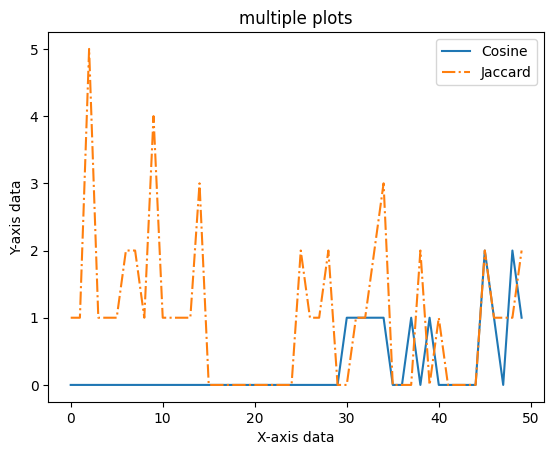

In [271]:
#grafik garis dari seluruh indeks
import numpy as np 
import matplotlib.pyplot as plt 
  
from matplotlib.pyplot import figure

y1 = int_df['MAE_Cos']
x =  range(0, 50)
y2 = int_df['MAE_Jac']
plt.plot(x, y1, label ='Cosine')
plt.plot(x, y2, '-.', label ='Jaccard')

plt.xlabel("X-axis data")
plt.ylabel("Y-axis data")
plt.legend()
plt.title('multiple plots')
plt.show()

#### visualisasi sama sama salah

[1, 1, 1, 1, 2, 1, 2, 1]
[1, 1, 2, 3, 2, 1, 1, 2]


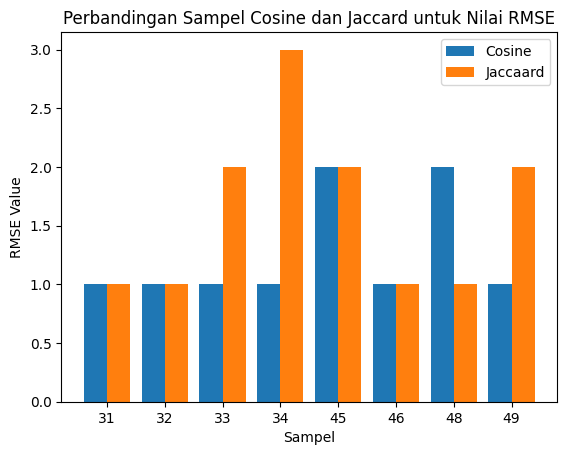

In [329]:
import numpy as np 
import matplotlib.pyplot as plt 


def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center' )

X = sama_sama_salah

y1 = int_df.iloc[X]['MAE_Cos'].tolist()
y2 = int_df.iloc[X]['MAE_Jac'].tolist()

print(y1)
print(y2)

Cos = y1
Jac = y2
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, Cos, 0.4, label = 'Cosine')
plt.bar(X_axis + 0.2, Jac, 0.4, label = 'Jaccaard')
  
  
plt.xticks(X_axis, X)
plt.xlabel("Sampel")
plt.ylabel("RMSE Value")
plt.title("Perbandingan Sampel Cosine dan Jaccard untuk Nilai RMSE")
plt.legend()
plt.show()

#### Visualisasi cosine benar jaccard salah

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 5, 1, 1, 1, 2, 2, 1, 4, 1, 1, 1, 1, 3, 2, 1, 1, 2, 2, 1, 1]


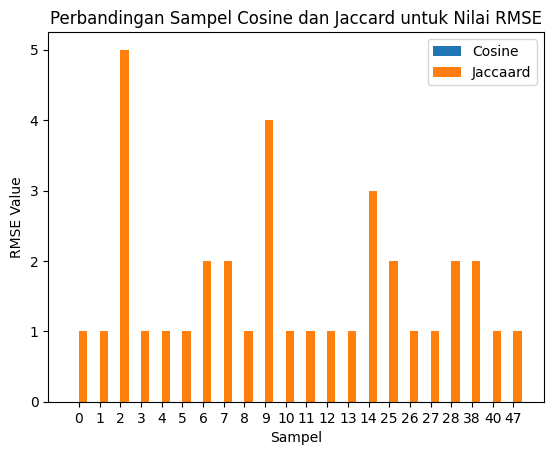

In [330]:
import numpy as np 
import matplotlib.pyplot as plt 


def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center' )

X = cosine_benar_jaccard_salah

y1 = int_df.iloc[X]['MAE_Cos'].tolist()
y2 = int_df.iloc[X]['MAE_Jac'].tolist()

print(y1)
print(y2)

Cos = y1
Jac = y2
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, Cos, 0.4, label = 'Cosine')
plt.bar(X_axis + 0.2, Jac, 0.4, label = 'Jaccaard')
  
  
plt.xticks(X_axis, X)
plt.xlabel("Sampel")
plt.ylabel("RMSE Value")
plt.title("Perbandingan Sampel Cosine dan Jaccard untuk Nilai RMSE")
plt.legend()
plt.show()

[1, 1, 1]
[0, 0, 0]


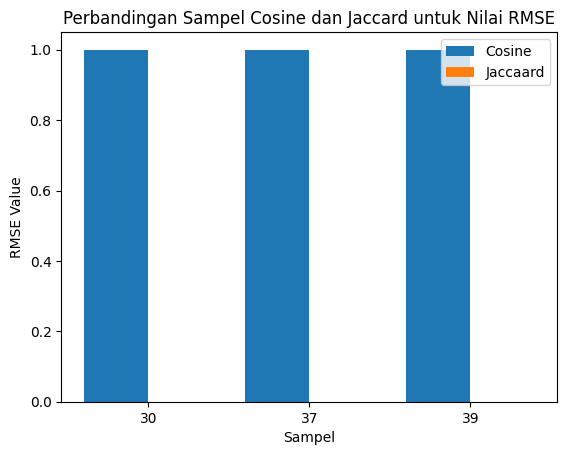

In [331]:
import numpy as np 
import matplotlib.pyplot as plt 


def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center' )

X = cosine_salah_jaccard_benar

y1 = int_df.iloc[X]['MAE_Cos'].tolist()
y2 = int_df.iloc[X]['MAE_Jac'].tolist()

print(y1)
print(y2)

Cos = y1
Jac = y2
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, Cos, 0.4, label = 'Cosine')
plt.bar(X_axis + 0.2, Jac, 0.4, label = 'Jaccaard')
  
  
plt.xticks(X_axis, X)
plt.xlabel("Sampel")
plt.ylabel("RMSE Value")
plt.title("Perbandingan Sampel Cosine dan Jaccard untuk Nilai RMSE")
plt.legend()
plt.show()

# tembak 


In [274]:

df_rekomendasi = pd.read_csv('hasilakhir.csv', delimiter=',')
df_rekomendasi.head()

,Index,Judul,Aktual,Deskripsi,Rubrik,Tag,Cossine Rekomend,Jaccard Recommned,MAE_Cos,MAE_Jac,MAE_Cos2,MAE_Jac2
0,0,"Jelang KTT G20, Menko Luhut Resmikan PLTS Tera...","[1, 2, 3, 4, 5]",jelang ktt g menko luhut resmi plts apung mili...,Nasional,"plts terapung, energi baru terbarukan, PLN","[3, 5, 4, 1, 2]",[3 5 4 7 1],0,1,0,1
1,1,PLN Berhasil Reduksi 32 Juta Metrik Ton Emisi ...,"[0, 2, 3, 4, 5]",pln hasil reduksi juta metrik ton emisi karbon...,Nasional,"reduksi, emisi karbon, PLN","[5, 3, 0, 4, 2]",[ 5 4 3 0 50],0,1,0,1
2,2,Instalasi PLN Dua Pekon di Suoh Masuk Roadmap ...,"[0, 1, 3, 4, 5]",instalasi pln pekon suoh masuk roadmap pln pas...,Nasional,"roadmap, instalasi, listrik, jaringan, PLN","[0, 3, 5, 1, 4]",[52 50 58 48 40],0,5,0,25
3,3,"Jelang KTT G20, PLN Pamerkan Dua PLTS dan 33 P...","[0, 1, 2, 4, 5]",jelang ktt g pln pamer plts pv rooftop bal pt ...,Nasional,"plts, g20, PLN","[0, 5, 4, 1, 2]",[ 4 5 0 1 19],0,1,0,1
4,4,"Jaga Pasokan Listrik KTT G20, PLN Operasikan P...","[0, 1, 2, 3, 5]",jaga pasok listrik ktt g pln operasi pltg relo...,Nasional,"pltg, g20, pasokan listrik, PLN","[3, 0, 5, 1, 2]",[ 3 5 0 1 44],0,1,0,1


In [275]:
df_rekomendasi.head()

,Index,Judul,Aktual,Deskripsi,Rubrik,Tag,Cossine Rekomend,Jaccard Recommned,MAE_Cos,MAE_Jac,MAE_Cos2,MAE_Jac2
0,0,"Jelang KTT G20, Menko Luhut Resmikan PLTS Tera...","[1, 2, 3, 4, 5]",jelang ktt g menko luhut resmi plts apung mili...,Nasional,"plts terapung, energi baru terbarukan, PLN","[3, 5, 4, 1, 2]",[3 5 4 7 1],0,1,0,1
1,1,PLN Berhasil Reduksi 32 Juta Metrik Ton Emisi ...,"[0, 2, 3, 4, 5]",pln hasil reduksi juta metrik ton emisi karbon...,Nasional,"reduksi, emisi karbon, PLN","[5, 3, 0, 4, 2]",[ 5 4 3 0 50],0,1,0,1
2,2,Instalasi PLN Dua Pekon di Suoh Masuk Roadmap ...,"[0, 1, 3, 4, 5]",instalasi pln pekon suoh masuk roadmap pln pas...,Nasional,"roadmap, instalasi, listrik, jaringan, PLN","[0, 3, 5, 1, 4]",[52 50 58 48 40],0,5,0,25
3,3,"Jelang KTT G20, PLN Pamerkan Dua PLTS dan 33 P...","[0, 1, 2, 4, 5]",jelang ktt g pln pamer plts pv rooftop bal pt ...,Nasional,"plts, g20, PLN","[0, 5, 4, 1, 2]",[ 4 5 0 1 19],0,1,0,1
4,4,"Jaga Pasokan Listrik KTT G20, PLN Operasikan P...","[0, 1, 2, 3, 5]",jaga pasok listrik ktt g pln operasi pltg relo...,Nasional,"pltg, g20, pasokan listrik, PLN","[3, 0, 5, 1, 2]",[ 3 5 0 1 44],0,1,0,1


In [276]:
indices = pd.Series(df_rekomendasi.index, index=df_rekomendasi['Judul']).drop_duplicates()
indices

Judul
Jelang KTT G20, Menko Luhut Resmikan PLTS Terapung Milik PLN di Bali                                              0
PLN Berhasil Reduksi 32 Juta Metrik Ton Emisi Karbon di Tahun 2022                                                1
Instalasi PLN Dua Pekon di Suoh Masuk Roadmap PLN 2023                                                            2
Jelang KTT G20, PLN Pamerkan Dua PLTS dan 33 PV Rooftop di Bali                                                   3
Jaga Pasokan Listrik KTT G20, PLN Operasikan PLTG Relokasi Dari Grati ke Bali                                     4
Mirota Kampus Buka Lowongan Kerja Bagian Operator Moulding, Simak Persyaratannya                                  5
BRI Kembali Buka Program Management Trainee, BRILiaN Future Leader Program                                        6
PT Petrolindo Megah Perkasa Buka Lowongan Kerja Bagi Lulusan D3, Simak Persyaratannya                             7
PT KAI Properti Buka Lowongan Kerja Bagian IT Supervisor, Berikut 

In [277]:
df_rekomendasi['Judul'].iloc[x]


0     Jelang KTT G20, Menko Luhut Resmikan PLTS Tera...
1     PLN Berhasil Reduksi 32 Juta Metrik Ton Emisi ...
2     Instalasi PLN Dua Pekon di Suoh Masuk Roadmap ...
3     Jelang KTT G20, PLN Pamerkan Dua PLTS dan 33 P...
4     Jaga Pasokan Listrik KTT G20, PLN Operasikan P...
5     Mirota Kampus Buka Lowongan Kerja Bagian Opera...
6     BRI Kembali Buka Program Management Trainee, B...
7     PT Petrolindo Megah Perkasa Buka Lowongan Kerj...
8     PT KAI Properti Buka Lowongan Kerja Bagian IT ...
9     Pertumbuhan Angkatan Kerja dan Lowongan Kerja ...
10    Muncul Dukungan Jokowi Jadi Ketum PDIP 2024, P...
11    Bepesan Agar Golkar Jangan Sembrono Pilih Capr...
12    Pesan Jokowi Saat Hadiri Acara Puncak HUT ke-5...
13    Dari Kapolri, Kapolda, Kapolresta dan Kapolres...
14    Panggil Pejabat Polri Tanpa Ajudan, Begini Pen...
15    Bareskrim Polri Akan Panggil Petinggi Afi Farm...
16    Begini Modus Perusahaan Pemasok Bahan Baku Sir...
17    Kasus Gagal Ginjal Akut, Ada Dua Perusahaa

In [278]:
import re
def Rekomen_Cos (title) :
    x = df_rekomendasi[df_rekomendasi['Judul'] == title]['Cossine Rekomend'].values[0]
    x = re.findall(r'\d+', x)
    x = df_rekomendasi['Judul'].iloc[x]
    return x

def Rekomen_Jac (title) :
    y = df_rekomendasi[df_rekomendasi['Judul'] == title]['Jaccard Recommned'].values[0]
    y = re.findall(r'\d+', x)
    y = df_rekomendasi['Judul'].iloc[x]
    return y




In [279]:
def Rekomen_Cos (title) :
    if title in indices:
        x = df_rekomendasi[df_rekomendasi['Judul'] == title]['Cossine Rekomend'].values[0]
        x = re.findall(r'\d+', x)
        x = list(map(int, x))
        x = df_rekomendasi['Judul'][x]
        return x
    else : return ("Tidak ada  berita seperti itu")
    

In [280]:
x = [9,10,11]
df_rekomendasi['Judul'][x]

9     Pertumbuhan Angkatan Kerja dan Lowongan Kerja ...
10    Muncul Dukungan Jokowi Jadi Ketum PDIP 2024, P...
11    Bepesan Agar Golkar Jangan Sembrono Pilih Capr...
Name: Judul, dtype: object

In [281]:
title = 'Melalui Matching Fund, UBL Riset Bersama PT Angkasa Wiratama'


In [282]:
x = df_rekomendasi[df_rekomendasi['Judul'] == title]['Cossine Rekomend'].values[0]
x = re.findall(r'\d+', x)
x = list(map(int, x))
x

[34, 33, 30, 31, 35]

In [283]:
df2=df_rekomendasi[df_rekomendasi.index.isin(x)]
df2['Judul']

30             Hyundai STARGAZER Resmi Hadir di Lampung
31    Test Drive Hyundai Stargazer, Intip Kenyamanan...
33       Intip Yuk, 43 Unit Hyundai Ramaikan GIIAS 2022
34    Jajal Mobil Listrik Hyundai, Bupati Tanggamus ...
35    Pasca Kerusuhan Kanjuruhan, Polri Susun Aturan...
Name: Judul, dtype: object

In [284]:
title = 'Melalui Matching Fund, UBL Riset Bersama PT Angkasa Wiratama'
x = df_rekomendasi[df_rekomendasi['Judul'] == title]['Jaccard Recommned'].values[0]
#x = re.findall(r'\d+', x)
x

'[34 33 30 31  6]'

In [285]:
def Rekomen_Jac (title) :
    if title in indices:    
        x = df_rekomendasi[df_rekomendasi['Judul'] == title]['Jaccard Recommned'].values[0]
        x = re.findall(r'\d+', x)
        x = res = [eval(i) for i in x]
        df2=df_rekomendasi[df_rekomendasi.index.isin(x)]
        y = df2['Judul'].tolist()
        return y
    else : return ("Tidak ada  berita seperti itu")


In [286]:
title = 'Jelang KTT G20, Menko Luhut Resmikan PLTS Terapung Milik PLN di Bali'
x = Rekomen_Jac (title)



### notebook



indeks perbedaan : 9, 14, 25, 31, 45, 46, 47